# Example notebook

> Image classifier with fastai. Papersweep will call this notebook and run it with multiple models

In [1]:
# papermill parameters (this cell is tagged as 'parameters' in Jupyter)
install_deps = True
stable = True # True: latest version, False: stable version

In [2]:
import sys
ISCOLAB = 'google.colab' in sys.modules
if ISCOLAB or install_deps:
    if stable: 
        !pip install tsai -q
    else:
        !pip install git+https://github.com/timeseriesAI/tsai.git -q
    
import tsai
from tsai.all import *
print('tsai       :', tsai.__version__)
print('fastai     :', fastai.__version__)
print('fastcore   :', fastcore.__version__)
print('torch      :', torch.__version__)

tsai       : 0.2.7
fastai     : 2.1.7
fastcore   : 1.3.9
torch      : 1.7.0


In [3]:
import wandb
from fastai.callback.wandb import *

In [4]:
%%capture
wandb.init(entity="vrodriguezf", project = "papersweep")

In [5]:
wandb.run.get_url()

'https://wandb.ai/vrodriguezf/papersweep/runs/q7uucjqf'

WandbCallback requires use of "SaveModelCallback" to log best model
WandbCallback was not able to prepare a DataLoader for logging prediction samples -> tuple index out of range


epoch,train_loss,valid_loss,accuracy,time
0,1.774477,2.263812,0.294444,00:00
1,1.750868,1.988131,0.288889,00:00
2,1.647547,1.764252,0.305556,00:00
3,1.524360,1.531631,0.322222,00:00
4,1.381738,1.309899,0.538889,00:00
5,1.243327,1.108531,0.577778,00:00
6,1.121324,0.860280,0.755556,00:00
7,1.013188,0.647246,0.822222,00:00
8,0.917805,0.524953,0.827778,00:00
9,0.834310,0.462798,0.816667,00:00


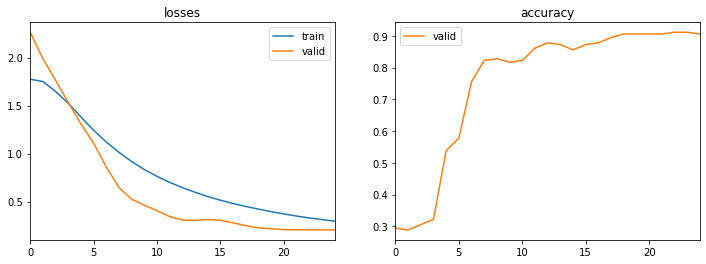

In [6]:
wandb.config.dsid = ifnone(wandb.config.get('dsid'), 'NATOPS')
X, y, splits = get_UCR_data(wandb.config.dsid, return_split=False)
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128], batch_tfms=[TSStandardize()], num_workers=0)
wandb.config.arch = ifnone(wandb.config.get('arch'), 'InceptionTime')
k = {}
model = create_model(eval(wandb.config.arch), dls=dls, **k)
learn = Learner(dls, model, metrics=accuracy)
learn.fit_one_cycle(25, lr_max=1e-3, cbs=[WandbCallback()])
learn.recorder.plot_metrics()